# Experiment - Readout `W_out` Samples Subpopulation

February 9, 2022

The goal here is to address the question of what happens in the following scenario:

1. The decoder is reading out from a smaller population of neurons
2. The internal model M is updating _all_ the neurons

The way I do this, is I first pretrain the weights `w_rec` and `w_out`, set a handful of `w_out` values to zero, and then create two networks that use this new, reduced readout. One of the networks, however, uses a (presumably high-rank) matrix `M` that is the transpose of the original pretrained decoder `w_out`, whihle the other network uses the new, (presumably low-rank) matrix `w_out.T`

**Conclusion**

Both networks are capable of learning the task, although the one with a non-updated `M` matrix takes longer.

-------

Note: It is important to use `np.copy()` with earnest, as strange things can happen if I don't copy things properly (the python default for `a = b` seems to be a pointer to the same object `b`)

I do this in the following code snippet:
```
# Initialize RNNs
net1 = RNN(params)
net2 = RNN(params)

net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))
net2.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

w_out = np.copy(net1.w_out)
w_m = np.copy(w_out.T)

# select random indices to zero
ind = np.random.choice(np.arange(0,w_out.shape[1],1),30,replace=False)
w_out[0,ind] = 0
net1.set_weights(w_out=w_out.copy())
net1.set_weights(w_m=w_out.T.copy())

net2.set_weights(w_out=w_out.copy())
net2.set_weights(w_m = w_m.copy())
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Pretrain

29it [00:00, 287.33it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 5
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.05
rng: <mtrand.RandomState object at 0x7faeb0edfc18>
apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  True


150it [00:00, 376.38it/s]


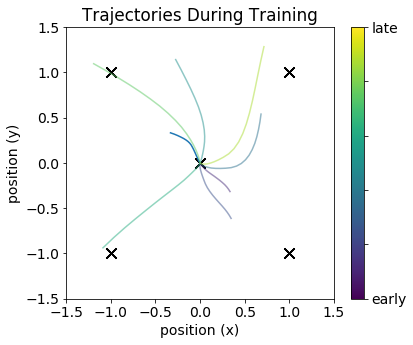

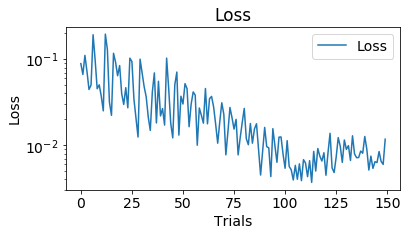

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.05,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net0 = RNN(params)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo0 = RFLO(net0,apply_to=['w_rec','w_out'],online=True,weight_transport=True)  
#bptt = BPTT(net0,apply_to=['w_rec','w_out'],online=False) # something strange happening here
rflo0.print_params()


sim0.run_session(n_trials=150, tasks=[task1,task2,task3,task4], learn_alg=[rflo0], probe_types=[], plot=True, plot_freq=20)


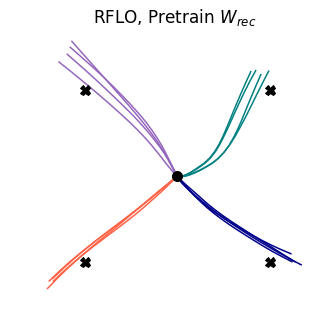

In [5]:
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='RFLO, Pretrain '+r'$W_{rec}$')


# Compare Two Networks

Create two identical networks, and train `w_rec` with unbiased and biased RFLO. In the biased case, matrix `w_m` is the transpose of the pretrained matrix `w_out`

In [6]:
# Initialize RNNs
net1 = RNN(params)
net2 = RNN(params)

net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))
net2.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

w_out = np.copy(net1.w_out)
w_m = np.copy(w_out.T)

# select random indices to zero
ind = np.random.choice(np.arange(0,w_out.shape[1],1),30,replace=False)
w_out[0,ind] = 0
net1.set_weights(w_out=w_out.copy())
net1.set_weights(w_m=w_out.T.copy())

net2.set_weights(w_out=w_out.copy())
net2.set_weights(w_m = w_m.copy())

w_out_flat = w_out.flatten()/np.linalg.norm(w_out.flatten())
w_m_flat = w_m.T.flatten()/np.linalg.norm(w_m.T.flatten())
alignment = np.dot(w_out_flat, w_m_flat)
print('alignment:{:.3f}'.format(alignment))

alignment:0.824


73it [00:00, 279.33it/s]

apply_to :  ['w_rec']
online :  False
weight_transport :  True


200it [00:00, 357.19it/s]


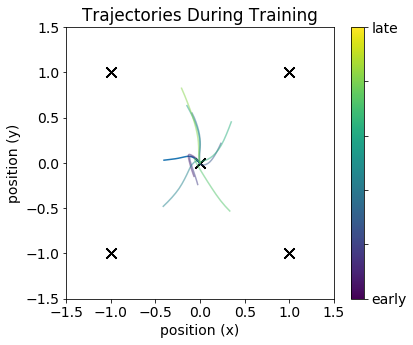

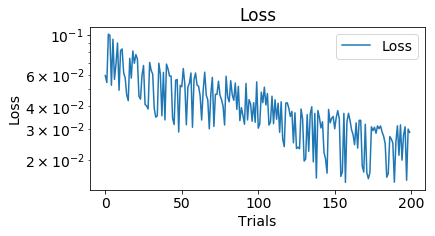

In [7]:
rflo1 = RFLO(net1,apply_to=['w_rec'],online=False,weight_transport=True)  
rflo1.print_params()

sim1 = Simulation(net1)
sim1.run_session(n_trials=200, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=[], plot=True, plot_freq=20)


21it [00:00, 198.46it/s]

apply_to :  ['w_rec']
online :  False
weight_transport :  False


200it [00:00, 375.54it/s]


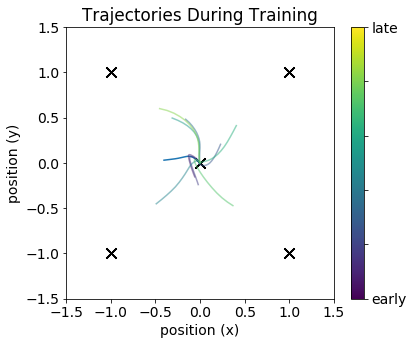

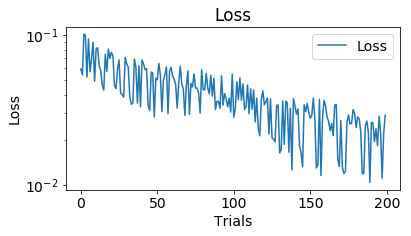

In [8]:
rflo2 = RFLO(net2,apply_to=['w_rec'],online=False,weight_transport=False) 
rflo2.print_params()

sim2 = Simulation(net2)
sim2.run_session(n_trials=200, tasks=[task1,task2,task3,task4], learn_alg=[rflo2], probe_types=[], plot=True, plot_freq=20)


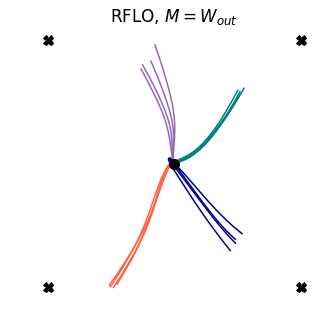

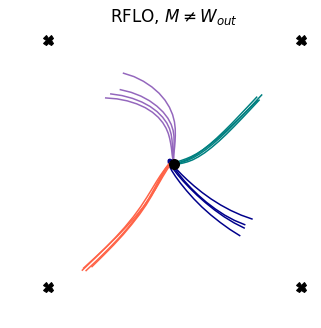

In [9]:
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='RFLO, '+r'$M=W_{out}$')
fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='RFLO, '+r'$M \neq W_{out}$')

In [10]:
print('>> In net1, w_m == w_out')
net1.w_m.T - net1.w_out

>> In net1, w_m == w_out


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [11]:
print('>> In net2, w_m nis not equal to w_out')
net2.w_m.T - net2.w_out

>> In net2, w_m nis not equal to w_out


array([[-0.2546475 , -0.23734382, -0.14371672,  0.27244639,  0.10856478,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.15484393,  0.        ,  0.        ,  0.        ,  0.19973533,
        -0.21644391,  0.03686769,  0.11741364,  0.        , -0.22866361,
         0.        , -0.12557293,  0.        ,  0.12433523,  0.        ,
        -0.1161551 ,  0.06074134,  0.        ,  0.28189052,  0.17791124,
         0.        ,  0.        ,  0.13152249,  0.24253589, -0.18576504,
         0.        , -0.22981724, -0.10296548, -0.06720987,  0.        ,
        -0.01611076,  0.12313217, -0.13054688,  0.        ,  0.        ,
        -0.03502643, -0.04405187,  0.        , -0.13035258, -0.08369689],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

## Compare with Backprop Through Time

In [12]:
net3 = RNN(params)

net3.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

net3.set_weights(w_out=w_out.copy())
net3.set_weights(w_m = w_m.copy())

26it [00:00, 255.18it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


200it [00:00, 397.41it/s]


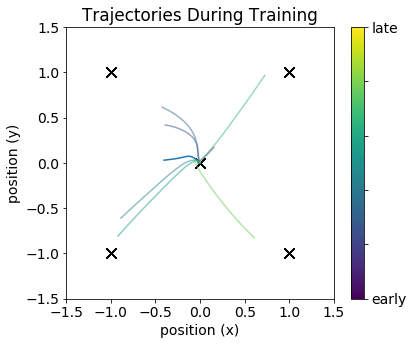

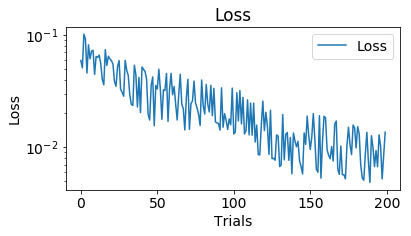

In [13]:


# initialize simulation
sim3 = Simulation(net3)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net3,apply_to=['w_rec'],online=False) 


sim3.run_session(n_trials=200, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=[], plot=True, plot_freq=25)


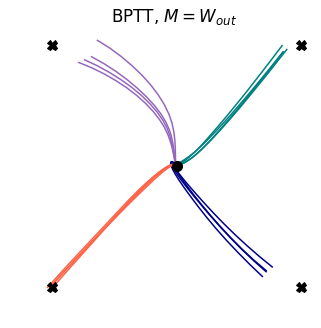

In [14]:
fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4],title='BPTT, '+r'$M=W_{out}$')


**Comments:** Note that we could theoretically look at bias in the weight transport matrix for BPTT. This is not implemented as of February 9, 2022. Also, it is hard to compare these scenarios without looking directly at changes in the loss...